# Определение стоимости автомобилей

**Описание проекта**

Целью данного проекта является создание модели машинного обучения для приложения сервиса по продаже автомобилей с пробегом "Не бит, не крашен". С помощью функционала данного сервиса компания планирует привлечь новых клиентов. Задачей предсказания модели является прогнозирование рыночной стоимости автомобиля клиента. Для создания модели предлагается использовать исторические данные, а именно технические характеристики, комплектации и цены автомобилей. 

Основные требования к модели включают в себя качество предсказания по метрике RMSE (не более 2500), скорость предсказания и время обучения. Одной из исследуемых моделей должна быть модель LightGBM, также требуется изучить одну модель без бустинга.
<br></br>

В данных для обучения имеются следующие признаки:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

В том числе целевой признак:

- Price — цена (евро)

## Подготовка данных

<h3>Загрузка данных</h3>

In [1]:
#libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statistics

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer

import catboost as ctb
import lightgbm as ltb
import time

%matplotlib inline

In [2]:
from IPython import display

In [3]:
sns.set_context('paper')
sns.set_style('whitegrid')

In [4]:
#random state
RS = 1212

data = pd.read_csv("autos.csv")

In [5]:
try:
    data = pd.read_csv("https://code.s3.yandex.net/datasets/autos.csv")
except:
    data = pd.read_csv("/datasets/autos.csv")

<h3>Изучение данных</h3>

In [6]:
DF_LEN = data.shape[0]

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Приведем названия столбцов к "змеиному" регистру:

In [8]:
def snake_case(column):
    """
    converts a CamelCase string to snake_case
    """
    snake_case = ''
    for i in range(len(column)):
        if (column[i].isupper()) & (i == 0):
            snake_case += column[i].lower()
        elif column[i].isupper():
            snake_case += "_" + column[i].lower()
        else:
            snake_case += column[i]
    return snake_case

In [9]:
column_list = list(map(snake_case, data.columns))
data.columns = column_list

In [10]:
data.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [11]:
data['date_crawled'].describe()

count                  354369
unique                 271174
top       2016-03-24 14:49:47
freq                        7
Name: date_crawled, dtype: object

In [12]:
data['date_crawled'].max()

'2016-04-07 14:36:58'

In [13]:
data['date_crawled'].min()

'2016-03-05 14:06:22'

In [14]:
data['date_created'].describe()

count                  354369
unique                    109
top       2016-04-03 00:00:00
freq                    13719
Name: date_created, dtype: object

In [15]:
data['date_created'].max()

'2016-04-07 00:00:00'

In [16]:
data['date_created'].min()

'2014-03-10 00:00:00'

In [17]:
data.describe().style.format("{:,.2f}")

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,"354,369.00","354,369.00","354,369.00","354,369.00","354,369.00","354,369.00","354,369.00"
mean,"4,416.66","2,004.23",110.09,"128,211.17",5.71,0.00,"50,508.69"
std,"4,514.16",90.23,189.85,"37,905.34",3.73,0.00,"25,783.10"
min,0.00,"1,000.00",0.00,"5,000.00",0.00,0.00,"1,067.00"
25%,"1,050.00","1,999.00",69.00,"125,000.00",3.00,0.00,"30,165.00"
50%,"2,700.00","2,003.00",105.00,"150,000.00",6.00,0.00,"49,413.00"
75%,"6,400.00","2,008.00",143.00,"150,000.00",9.00,0.00,"71,083.00"
max,"20,000.00","9,999.00","20,000.00","150,000.00",12.00,0.00,"99,998.00"


In [18]:
data.duplicated().sum()

4

Итак, в нашем датасете 16 признаков и 354369 объектов. Среди признаков есть как категориальные, так и количественные. Видим, что есть пропущенные значения и явные дубликаты. Продолжим изучение данных, посмотрим на дубликаты:

<h4>Возраст объявлений</h4>

Обратим внимание на то, что максимальный год создания объявления - 2016, а годы регистрации имеются большие. 

In [19]:
data[data['registration_year'] > 2016]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23 00:00:00,0,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10 00:00:00,0,31139,2016-03-16 09:16:46
48,2016-03-25 14:40:12,7750,NaN,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN,2016-03-25 00:00:00,0,48499,2016-03-31 21:47:44
51,2016-03-07 18:57:08,2000,NaN,2017,manual,90,punto,150000,11,gasoline,fiat,yes,2016-03-07 00:00:00,0,66115,2016-03-07 18:57:08
57,2016-03-10 20:53:19,2399,NaN,2018,manual,64,other,125000,3,NaN,seat,no,2016-03-10 00:00:00,0,33397,2016-03-25 10:17:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354112,2016-03-11 15:49:51,3600,NaN,2017,manual,86,transit,150000,5,gasoline,ford,NaN,2016-03-11 00:00:00,0,32339,2016-03-12 05:45:02
354140,2016-03-29 16:47:29,1000,NaN,2017,manual,101,a4,150000,9,NaN,audi,NaN,2016-03-29 00:00:00,0,38315,2016-04-06 02:44:27
354203,2016-03-17 00:56:26,2140,NaN,2018,manual,80,fiesta,150000,6,NaN,ford,no,2016-03-17 00:00:00,0,44866,2016-03-29 15:45:04
354253,2016-03-25 09:37:59,1250,NaN,2018,NaN,0,corsa,150000,0,petrol,opel,NaN,2016-03-25 00:00:00,0,45527,2016-04-06 07:46:13


Таких объявлений достаточно много, похоже на техническую ошибку. Удалим объявления с годом регистрации моложе 2016 года, потому что невозможно опубликовать объявление о продаже автомообиля в 2016 году, если он зарегестрирован в 2019.

In [20]:
weird_year = data[data['registration_year'] > 2016].index

In [21]:
data.drop(weird_year, inplace=True)

In [22]:
data.reset_index(drop=True, inplace=True)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339839 entries, 0 to 339838
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        339839 non-null  object
 1   price               339839 non-null  int64 
 2   vehicle_type        316859 non-null  object
 3   registration_year   339839 non-null  int64 
 4   gearbox             321873 non-null  object
 5   power               339839 non-null  int64 
 6   model               322181 non-null  object
 7   kilometer           339839 non-null  int64 
 8   registration_month  339839 non-null  int64 
 9   fuel_type           312538 non-null  object
 10  brand               339839 non-null  object
 11  repaired            274984 non-null  object
 12  date_created        339839 non-null  object
 13  number_of_pictures  339839 non-null  int64 
 14  postal_code         339839 non-null  int64 
 15  last_seen           339839 non-null  object
dtypes:

<h3>Работа с дубликатами</h3>

In [24]:
data[data.duplicated()]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
164144,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
221796,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
247551,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
312353,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


Удалим эти явные дубликаты, сбросим индекс:

In [25]:
data.drop_duplicates(inplace=True)

In [26]:
data.reset_index(drop=True, inplace=True)

In [27]:
data.duplicated().sum()

0

Теперь посмотрим на дубликаты по столбцам `'vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'registration_month', 'fuel_type', 'brand'`:

In [28]:
dub_list = ['vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'registration_month', 'fuel_type', 'brand']

data[data.duplicated(subset=dub_list)]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
361,2016-03-10 14:45:46,1100,small,2000,manual,60,punto,60000,6,petrol,fiat,no,2016-03-10 00:00:00,0,87600,2016-03-11 02:16:04
565,2016-03-17 19:51:48,700,small,2001,manual,75,golf,150000,1,petrol,volkswagen,NaN,2016-03-17 00:00:00,0,22047,2016-03-17 19:51:48
924,2016-03-25 09:57:23,0,NaN,1990,NaN,0,3er,150000,0,NaN,bmw,NaN,2016-03-25 00:00:00,0,66822,2016-03-29 22:46:53
962,2016-03-20 23:06:24,10900,small,2010,auto,179,ibiza,80000,11,petrol,seat,no,2016-03-20 00:00:00,0,60322,2016-04-06 06:17:49
970,2016-03-26 19:48:43,500,small,1996,manual,45,corsa,70000,4,petrol,opel,no,2016-03-26 00:00:00,0,8496,2016-04-06 09:46:52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339822,2016-04-04 11:45:16,999,convertible,2000,manual,95,megane,150000,4,petrol,renault,NaN,2016-04-04 00:00:00,0,88477,2016-04-06 12:44:52
339824,2016-04-04 09:57:12,1490,small,1998,manual,50,lupo,150000,9,petrol,volkswagen,no,2016-04-04 00:00:00,0,48653,2016-04-06 11:17:13
339829,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,0,26624,2016-03-29 10:17:23
339831,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52


Посмотрим на первую машину подробнее:

In [29]:
data[(data['model'] == 'punto') & (data['registration_month'] == 6) & (data['registration_year'] == 2000) & \
     (data['power'] == 60)].sort_values(by='date_crawled')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
221805,2016-03-05 14:46:28,1290,small,2000,manual,60,punto,125000,6,petrol,fiat,no,2016-03-05 00:00:00,0,54290,2016-03-05 16:46:46
84490,2016-03-08 20:37:41,890,small,2000,manual,60,punto,150000,6,petrol,fiat,no,2016-03-08 00:00:00,0,73230,2016-04-05 18:44:44
361,2016-03-10 14:45:46,1100,small,2000,manual,60,punto,60000,6,petrol,fiat,no,2016-03-10 00:00:00,0,87600,2016-03-11 02:16:04
103715,2016-03-11 22:38:24,890,small,2000,manual,60,punto,150000,6,petrol,fiat,no,2016-03-11 00:00:00,0,73230,2016-04-06 23:45:16
219993,2016-03-12 13:47:06,1700,small,2000,manual,60,punto,80000,6,petrol,fiat,no,2016-03-12 00:00:00,0,13359,2016-04-06 21:17:29
194178,2016-03-12 16:53:46,1700,small,2000,manual,60,punto,80000,6,petrol,fiat,no,2016-03-12 00:00:00,0,13359,2016-04-07 07:17:27
237127,2016-03-13 14:46:08,500,small,2000,manual,60,punto,150000,6,petrol,fiat,yes,2016-03-13 00:00:00,0,66780,2016-04-06 16:16:26
6256,2016-03-14 08:53:35,999,small,2000,manual,60,punto,150000,6,petrol,fiat,no,2016-03-14 00:00:00,0,91301,2016-03-14 09:39:15
44768,2016-03-17 15:36:21,1500,small,2000,manual,60,punto,125000,6,petrol,fiat,no,2016-03-17 00:00:00,0,32469,2016-03-24 11:15:40
274552,2016-03-20 01:57:03,1650,small,2000,manual,60,punto,100000,6,petrol,fiat,no,2016-03-20 00:00:00,0,27637,2016-04-06 03:15:22


Видим, что есть два наблюдения по одной машине с ценой 1700, у которых разные только `date_crawled` и `last_seen`, `date_created` - одинаковые.

Посмотрим подробнее `date_crawled` и `date_created`:

In [30]:
data.head(3).sort_values(by='date_created')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50


In [31]:
data.head(3).sort_values(by='date_created', ascending=False)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


In [32]:
data.head(3).sort_values(by='date_crawled')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57


In [33]:
data.head(3).sort_values(by='date_crawled', ascending=False)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


Получается, что объявления выгружались в день их создания пользователями.

In [34]:
data['number_of_pictures'].value_counts()

0    339835
Name: number_of_pictures, dtype: int64

Для нашей модели признаки `date_crawled`, `date_created`, `postal_code`, `last_seen` нерелевантны, так как они не дают информацию об автомобиле, а лишь об объявлении, причем речь идет о половине месяца, то есть предположения о том, как влияет состояние рынка на цену автомобиля по такому промежутку строить нельзя, следовательно, для машинного обучения этот признак не несет информации. 

Столбец `registration_month` тоже следует убрать, потому что год регистрации имеет гораздо большее влияние, но пока оставим его, чтобы иметь возможность правильно найти дубликаты.

Столбец `number_of_pictures` - количество фотографий в объявлении - скорее всего, количество фото действительно влияет на цену продажи, но в данном случае у нас везде 0, поэтому тоже удалим этот столбец и посмотрим дубликаты заново.

<h3>Удаление нерелевантных признаков</h3>

In [35]:
data.drop(columns=['date_crawled', 'date_created', 'postal_code', 'last_seen', 'number_of_pictures'],\
          inplace=True)

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339835 entries, 0 to 339834
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               339835 non-null  int64 
 1   vehicle_type        316855 non-null  object
 2   registration_year   339835 non-null  int64 
 3   gearbox             321869 non-null  object
 4   power               339835 non-null  int64 
 5   model               322177 non-null  object
 6   kilometer           339835 non-null  int64 
 7   registration_month  339835 non-null  int64 
 8   fuel_type           312534 non-null  object
 9   brand               339835 non-null  object
 10  repaired            274980 non-null  object
dtypes: int64(5), object(6)
memory usage: 28.5+ MB


У нас осталось 9 признаков, влияющих на цену автомобиля.
Изучим дубликаты еще раз:

<h3>Работа с дубликатами v.2</h3>

In [37]:
data.duplicated().sum()

26840

Мы обнаружили почти 27 тысяч полностью дублирующихся объявлений после удаления нерелевантных столбцов. Отбросим их:

In [38]:
data.drop_duplicates(inplace=True)

In [39]:
data.reset_index(drop=True, inplace=True)

Посмотрим на прежде дублируемый fiat punto:

In [40]:
data.query('model == "punto" & power == 60 & registration_year == 2000 & registration_month == 6')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
347,1490,small,2000,manual,60,punto,100000,6,petrol,fiat,no
361,1100,small,2000,manual,60,punto,60000,6,petrol,fiat,no
6239,999,small,2000,manual,60,punto,150000,6,petrol,fiat,no
44061,1500,small,2000,manual,60,punto,125000,6,petrol,fiat,no
82304,890,small,2000,manual,60,punto,150000,6,petrol,fiat,no
127276,650,small,2000,manual,60,punto,150000,6,petrol,fiat,no
184410,1700,small,2000,manual,60,punto,80000,6,petrol,fiat,no
209332,1290,small,2000,manual,60,punto,125000,6,petrol,fiat,no
223025,500,small,2000,manual,60,punto,150000,6,petrol,fiat,yes
256148,1650,small,2000,manual,60,punto,100000,6,petrol,fiat,no


Получилось избавиться от дважды скачанных одинаковых объявлений, в которых различалась только дата скачивания и активность пользователя.

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312995 entries, 0 to 312994
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               312995 non-null  int64 
 1   vehicle_type        291558 non-null  object
 2   registration_year   312995 non-null  int64 
 3   gearbox             297192 non-null  object
 4   power               312995 non-null  int64 
 5   model               296428 non-null  object
 6   kilometer           312995 non-null  int64 
 7   registration_month  312995 non-null  int64 
 8   fuel_type           287241 non-null  object
 9   brand               312995 non-null  object
 10  repaired            252549 non-null  object
dtypes: int64(5), object(6)
memory usage: 26.3+ MB


In [42]:
data.describe()

,price,registration_year,power,kilometer,registration_month
count,312995.000000,312995.000000,312995.000000,312995.000000,312995.000000
mean,4459.604860,2002.270206,111.198093,127992.987108,5.737015
std,4551.655288,14.179993,192.942690,37970.833363,3.706190
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2750.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6499.000000,2007.000000,143.000000,150000.000000,9.000000
max,20000.000000,2016.000000,20000.000000,150000.000000,12.000000


Как и планировали, удалим столбец `registration_month`:

In [43]:
data.drop(columns='registration_month', inplace=True)

<h3>Работа с пропущенными значениями</h3>

In [44]:
data.isna().sum()

price                    0
vehicle_type         21437
registration_year        0
gearbox              15803
power                    0
model                16567
kilometer                0
fuel_type            25754
brand                    0
repaired             60446
dtype: int64

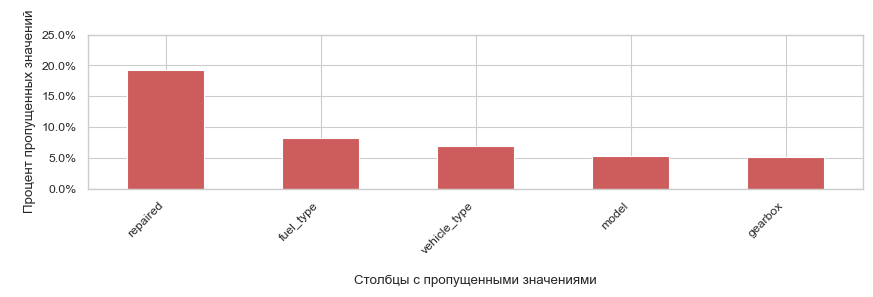

In [45]:
data_na = data.isna().sum().sort_values(ascending=False)/len(data)*100

ax = data_na[data_na>0].plot(kind='bar', figsize=(10,2), grid=True, color='indianred')
plt.ylim(0, 25)
ax.set(xlabel="\nСтолбцы с пропущенными значениями",
ylabel="\nПроцент пропущенных значений")
plt.xticks(rotation = 45, ha = 'right')

import matplotlib.ticker as mtick
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

Видим, что всего в 5 столбцах имеются пропущенные значения. 

В столбце `repaired` самая большая доля пропусков - 20%, в столбцах `vehicle_type` и `fuel_type` - около 8% пропусков, в столбцах `model` и `gearbox` - около 5%.

<h4>Столбец `repaired`</h4>

In [46]:
data['repaired'].value_counts()

no     219243
yes     33306
Name: repaired, dtype: int64

In [47]:
data['repaired'].isna().sum()

60446

In [48]:
repair = data[data['repaired'] == 'yes']['repaired'].count()
no_repair = data[data['repaired'] == 'no']['repaired'].count()
total_repaired = repair / (repair + no_repair) * 100
total_no_repaired = 100 - total_repaired

print(f"Доля машин без ремонта составляет {total_no_repaired:.2f}\n\nДоля машин с ремонтом составляет {total_repaired:.2f}")

Доля машин без ремонта составляет 86.81

Доля машин с ремонтом составляет 13.19


Данный признак является бинарным, он несет информацию о том, была машина в ремонте или нет. Всего в нем около 66 тысяч пропущенных значений.

Машин без ремонта примерно 87%, машин с ремонтом - около 13%. Пропущенных наблюдений - 20% от всех.

20% пропущенных значений это достаточно много, но мы не можем знать, была ли машина в ремонте или нет. Также мотивы пользователей не указывать информацию об этом могут быть противоположными: например, не счесть нужным указать, потому что не ремонтировалась, или наоборот, чтобы скрыть факт ремонта.

Выбросить такое количество наблюдений - не самый лучший вариант, заполнить их одним из бинарных вариантов не представляется возможным, поэтому присвоим пропущенным значениям третью категорию - `not specified`.

In [49]:
data['repaired'].fillna('not specified', inplace=True)

In [50]:
data['repaired'].value_counts()

no               219243
not specified     60446
yes               33306
Name: repaired, dtype: int64

Отлично, теперь мы имеем категориальный признак. Перейдем к рассмотрению следующего столбца с пропусками:

<h4>Столбец `vehicle_type`</h4>

In [51]:
data['vehicle_type'].isna().sum()

21437

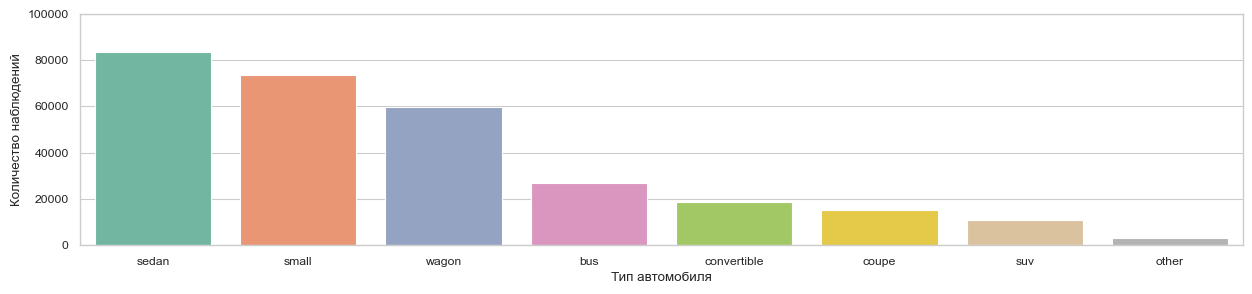

In [52]:
plt.figure(figsize=(15, 3))

sns.countplot(x=data['vehicle_type'], order = data['vehicle_type'].value_counts().index, palette='Set2')

plt.xlabel("Тип автомобиля")
plt.ylabel("Количество наблюдений")
plt.ylim(0, 100000)
plt.show()

In [53]:
data['vehicle_type'].value_counts().sort_values(ascending=False)

sedan          83599
small          73492
wagon          59658
bus            26793
convertible    18751
coupe          15117
suv            10976
other           3172
Name: vehicle_type, dtype: int64

In [54]:
data[data['vehicle_type'].isna()].head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,not specified
16,300,NaN,2016,NaN,60,polo,150000,petrol,volkswagen,not specified
29,899,NaN,2016,manual,60,clio,150000,petrol,renault,not specified
33,350,NaN,2016,manual,75,golf,150000,petrol,volkswagen,no
35,1500,NaN,2016,NaN,0,kangoo,150000,gasoline,renault,no


In [55]:
data.query("model == 'golf'").head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,not specified
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,not specified
30,245,sedan,1994,NaN,0,golf,150000,petrol,volkswagen,no
33,350,NaN,2016,manual,75,golf,150000,petrol,volkswagen,no


Видим, что для одной и той же модели авто - `volkswagen golf` - указаны разные типы - `small` и `sedan`. Это нормально, потому что одна модель может выпускаться в разных кузовах. 

Заполним пропущенные значения модой по модели авто.

In [56]:
data = data.assign(brand_model=data.brand.astype(str) + " _ " + data.model.astype(str))

In [57]:
data['vehicle_type'] = data['vehicle_type'].fillna(
    data.groupby(['brand_model'])['vehicle_type']
        .transform(lambda s: pd.Series.mode(s).get(0))
)

In [58]:
data['vehicle_type'].isna().sum()

0

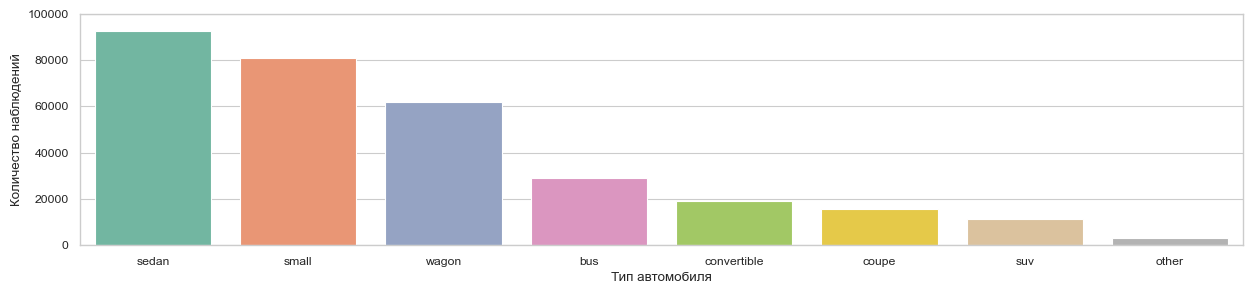

In [59]:
plt.figure(figsize=(15, 3))

sns.countplot(x=data['vehicle_type'], order = data['vehicle_type'].value_counts().index, palette='Set2')

plt.xlabel("Тип автомобиля")
plt.ylabel("Количество наблюдений")
plt.ylim(0, 100000)
plt.show()

In [60]:
data['vehicle_type'].value_counts().sort_values(ascending=False)

sedan          92645
small          80762
wagon          61788
bus            28789
convertible    18933
coupe          15550
suv            11341
other           3187
Name: vehicle_type, dtype: int64

Значительнее всего увеличились категории `sedan` и `small`. Порядок категорий не изменился после заполнения модой по модели и бренду. Рассмотрим следующий столбец:

<h4>Столбец `fuel_type`</h4>

In [61]:
data['fuel_type'].value_counts()

petrol      194253
gasoline     87192
lpg           4790
cng            506
hybrid         220
other          192
electric        88
Name: fuel_type, dtype: int64

In [62]:
data['fuel_type'].isna().sum()

25754

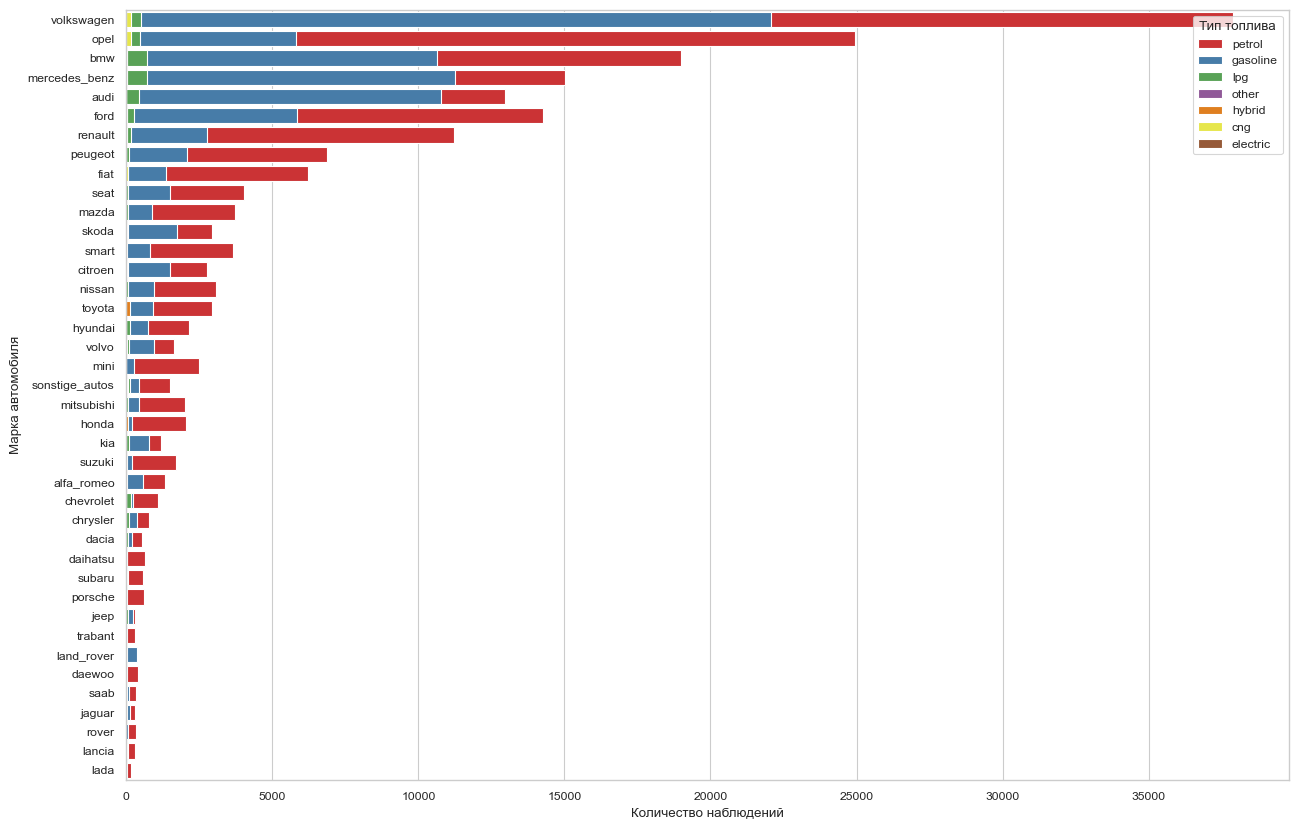

In [63]:
plt.figure(figsize=(15, 10))

sns.countplot(y=data['brand'], hue=data['fuel_type'], dodge=False, order=data['brand'].value_counts().index, palette='Set1')
plt.ylabel("Марка автомобиля")
plt.xlabel("Количество наблюдений")
plt.legend(title="Тип топлива")
plt.show()

По всем маркам автомобилей наибольшая доля у типов топлива `petrol` и `gasoline`. Эти два слова обозначают одно и то же - бензин, но, скорее всего, в конкретном наборе данных под одним из них имелось в виду дизельное топливо. Исходя из их соотношения, скорее всего, дизельное топливо здесь - это `petrol`.

Пропущенных значений довольно много, примерно 26 тысяч, заполним их модой по марке и модели автомобилей.

In [64]:
data['fuel_type'] = data['fuel_type'].fillna(
    data.groupby(['brand_model'])['fuel_type']
        .transform(lambda s: pd.Series.mode(s).get(0))
)

In [65]:
data['fuel_type'].value_counts()

petrol      216189
gasoline     91010
lpg           4790
cng            506
hybrid         220
other          192
electric        88
Name: fuel_type, dtype: int64

In [66]:
data['fuel_type'].isna().sum()

0

Порядок категорий по возрастанию не изменился после заполнения.

<h4>Столбец `model`</h4>

In [67]:
data['model'].value_counts().head(10)

golf        24932
other       22700
3er         17525
polo        11353
corsa       10796
astra        9529
passat       8813
a4           8683
c_klasse     7365
5er          6962
Name: model, dtype: int64

In [68]:
data['model'].value_counts().tail(10)

gl                    12
amarok                12
i3                     8
elefantino             8
serie_2                7
kalina                 5
serie_3                4
rangerover             3
serie_1                2
range_rover_evoque     1
Name: model, dtype: int64

In [69]:
data['model'].isna().sum()

16567

In [70]:
(data['model'].isna().sum() / len(data) * 100).round(0)

5.0

В столбце `model`, обозначающем модель автомобиля, всего 5% пропусков. Полагаю, что это очень важный признак для расчета рыночной стоимости машины, а восстанавливать пропуски по имеющимся признакам не стоит из-за возможных ошибок. Удалим эти 6% наблюдений.

In [71]:
data.dropna(subset=['model'], inplace=True)

In [72]:
data.reset_index(drop=True, inplace=True)

In [73]:
data['model'].isna().sum()

0

In [74]:
(100 - len(data) / 354369 * 100)

16.350470836896008

К настоящему моменту при подготовке данных у нас ушло 16% датасета. Это произошло из-за наличия в данных дубликатов, пропусков, противоречащих друг другу признаков в виде даты публикации и года регистрации авто. Где возможно, мы заполнили пропуски, где нет, удалили данные. Полагаю, что это оправданная потеря, которая позволит сделать модели точнее.

<h4>Столбец `gearbox`</h4>

In [75]:
data['gearbox'].value_counts()

manual    227347
auto       56420
Name: gearbox, dtype: int64

In [76]:
data['gearbox'].isna().sum()

12661

Пропущенные значения в столбце `gearbox` - тип коробки передач - заполним модой по бренду и модели.

In [77]:
data['gearbox'] = data['gearbox'].fillna(
    data.groupby(['brand_model'])['gearbox']
        .transform(lambda s: pd.Series.mode(s).get(0))
)

In [78]:
data['gearbox'].isna().sum()

0

In [79]:
data['gearbox'].value_counts()

manual    238301
auto       58127
Name: gearbox, dtype: int64

Работа с пропущенными значениями завершена. Мы заполнили пропуски в следующих столбцах:

- `repaired`
- `vehicle_type`
- `fuel_type`
- `gearbox`

Удалили пропуски из:

- `model`

<h3>Поиск и устранение аномальных значений</h3>

In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296428 entries, 0 to 296427
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              296428 non-null  int64 
 1   vehicle_type       296428 non-null  object
 2   registration_year  296428 non-null  int64 
 3   gearbox            296428 non-null  object
 4   power              296428 non-null  int64 
 5   model              296428 non-null  object
 6   kilometer          296428 non-null  int64 
 7   fuel_type          296428 non-null  object
 8   brand              296428 non-null  object
 9   repaired           296428 non-null  object
 10  brand_model        296428 non-null  object
dtypes: int64(4), object(7)
memory usage: 24.9+ MB


In [81]:
study_list = ['price', 'registration_year', 'power', 'kilometer']
names = ['Цена', 'Год регистрации', 'Мощность', 'Пробег, км']

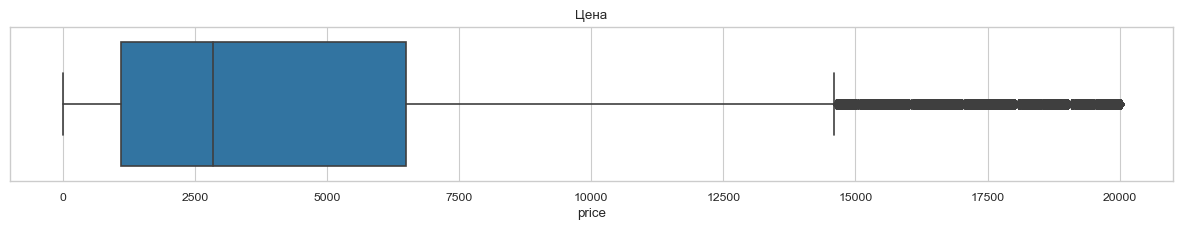

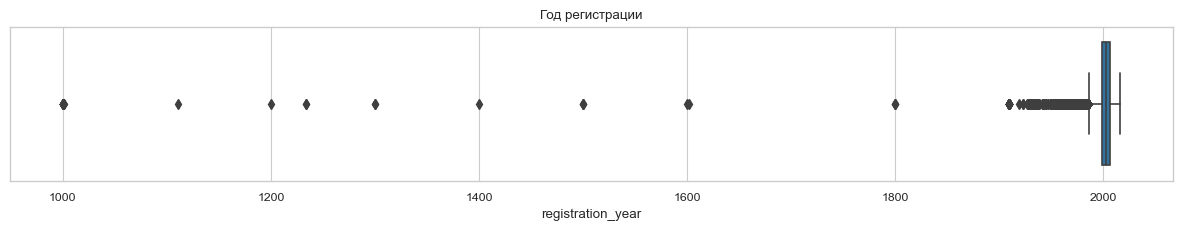

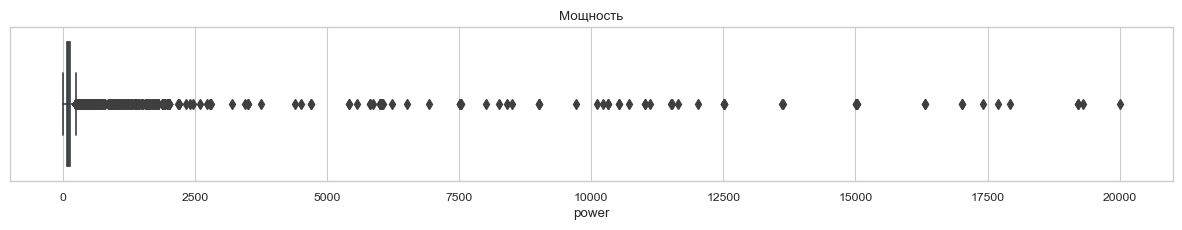

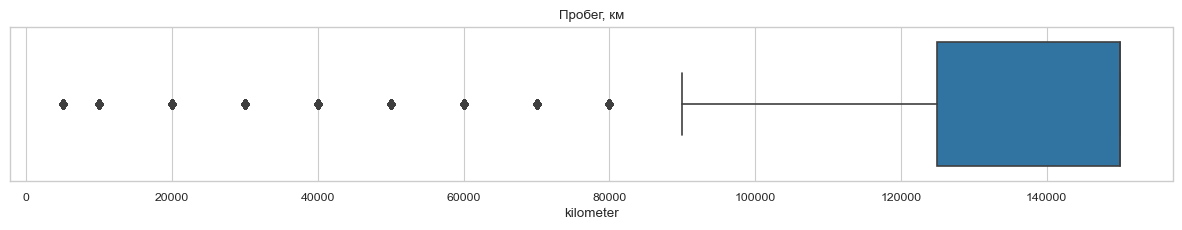

In [82]:
for i in range(len(study_list)):
    plt.figure(figsize=(15, 2))
    sns.boxplot(x=data[study_list[i]])
    plt.title(names[i])
    plt.show()

Видим, что есть проблемы с ценой - в каких-то наблюдениях она составляет 0 и, следовательно, является неинформативной для модели. В столбце с годом регистрации много аномалий, как и в столбце мощность. Пробег выглядит нормально.

Изучим подробнее столбцы с аномалиями:

<h4>Столбец `price`</h4>

In [83]:
data['price'].describe()

count    296428.000000
mean       4541.776253
std        4567.421704
min           0.000000
25%        1100.000000
50%        2850.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

In [84]:
data.query("price == 0")

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,brand_model
6,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no,volkswagen _ other
37,0,small,1990,manual,0,corsa,150000,petrol,opel,not specified,opel _ corsa
139,0,bus,2004,manual,101,meriva,150000,lpg,opel,yes,opel _ meriva
141,0,small,2006,manual,0,other,5000,petrol,fiat,not specified,fiat _ other
209,0,wagon,2001,manual,115,mondeo,150000,petrol,ford,not specified,ford _ mondeo
...,...,...,...,...,...,...,...,...,...,...,...
296299,0,small,2000,manual,65,corsa,150000,petrol,opel,yes,opel _ corsa
296326,0,small,2002,manual,60,fiesta,150000,petrol,ford,not specified,ford _ fiesta
296334,0,small,1999,manual,53,swift,150000,petrol,suzuki,not specified,suzuki _ swift
296358,0,small,1999,manual,37,arosa,150000,petrol,seat,yes,seat _ arosa


In [85]:
round(len(data[data['price'] == 0]) / len(data) * 100)

2

In [86]:
data['price'].sort_values().unique()[0:500]

array([   0,    1,    2,    3,    5,    7,    8,    9,   10,   11,   12,
         13,   14,   15,   16,   17,   18,   19,   20,   21,   24,   25,
         26,   27,   29,   30,   32,   33,   35,   38,   39,   40,   45,
         47,   49,   50,   55,   58,   59,   60,   65,   66,   69,   70,
         74,   75,   77,   79,   80,   85,   89,   90,   95,   98,   99,
        100,  101,  105,  108,  110,  111,  112,  115,  117,  119,  120,
        122,  123,  125,  126,  127,  128,  129,  130,  132,  133,  135,
        139,  140,  142,  145,  149,  150,  155,  156,  157,  159,  160,
        162,  165,  166,  169,  170,  173,  175,  177,  179,  180,  181,
        185,  188,  189,  190,  192,  193,  195,  196,  198,  199,  200,
        202,  205,  209,  210,  211,  215,  217,  219,  220,  222,  224,
        225,  229,  230,  235,  236,  238,  240,  243,  245,  248,  249,
        250,  251,  252,  253,  255,  259,  260,  261,  263,  265,  266,
        269,  270,  272,  273,  274,  275,  277,  2

In [87]:
data[data['price'] < 100]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,brand_model
6,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no,volkswagen _ other
37,0,small,1990,manual,0,corsa,150000,petrol,opel,not specified,opel _ corsa
80,1,sedan,1995,manual,113,e_klasse,150000,gasoline,mercedes_benz,no,mercedes_benz _ e_klasse
139,0,bus,2004,manual,101,meriva,150000,lpg,opel,yes,opel _ meriva
141,0,small,2006,manual,0,other,5000,petrol,fiat,not specified,fiat _ other
...,...,...,...,...,...,...,...,...,...,...,...
296326,0,small,2002,manual,60,fiesta,150000,petrol,ford,not specified,ford _ fiesta
296334,0,small,1999,manual,53,swift,150000,petrol,suzuki,not specified,suzuki _ swift
296358,0,small,1999,manual,37,arosa,150000,petrol,seat,yes,seat _ arosa
296382,99,small,1999,manual,60,arosa,150000,petrol,seat,yes,seat _ arosa


In [88]:
data.query("price == 1")

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,brand_model
80,1,sedan,1995,manual,113,e_klasse,150000,gasoline,mercedes_benz,no,mercedes_benz _ e_klasse
245,1,sedan,1990,manual,90,80,70000,petrol,audi,no,audi _ 80
371,1,sedan,2000,manual,75,golf,90000,petrol,volkswagen,not specified,volkswagen _ golf
816,1,coupe,1990,manual,0,other,150000,petrol,porsche,not specified,porsche _ other
876,1,wagon,1998,manual,136,omega,150000,petrol,opel,no,opel _ omega
...,...,...,...,...,...,...,...,...,...,...,...
295270,1,bus,2005,manual,101,other,150000,gasoline,nissan,yes,nissan _ other
295292,1,small,1998,manual,125,polo,150000,petrol,volkswagen,no,volkswagen _ polo
295465,1,wagon,2007,auto,200,3er,150000,gasoline,bmw,no,bmw _ 3er
295539,1,coupe,1990,manual,45,polo,150000,petrol,volkswagen,no,volkswagen _ polo


In [89]:
round(len(data[data['price'] < 100]) / len(data) * 100)

3

Получается, что у нас есть 3% наблюдений, в которых цена за автомобиль составляет менее 100 евро. В них входят 2% наблюдений, в которых цена равна нулю. Цена - это целевой признак, который должны будут предсказывать наши модели. На мой взгляд, лучше удалить эти 3% наблюдений, чтобы результаты предсказаний были точнее. 

Здесь нельзя сказать с уверенностью, что 0 обозначает пропуск, возможно, это техническая ошибка выгрузки данных, а также нельзя точно утверждать, чему соответствуют единица, двойка, тройка и тд. - может, это 100 евро, может, 1000, а может человек просто поставил 1 евро, чтобы у него забрали битую машину. На многих сайтах продажи автомобилей есть нижнее ограничение по цене, поэтому поставим его тоже. 

Удалим объекты с ценой менее 100 евро. 

In [90]:
price_anomaly_ind = data[data['price'] < 100].index

In [91]:
data.drop(price_anomaly_ind, inplace=True)

Посмотрим, как изменилась стоимость автомобилей:

In [92]:
data['price'].describe()

count    287427.000000
mean       4683.804347
std        4566.212719
min         100.000000
25%        1250.000000
50%        2998.000000
75%        6799.000000
max       20000.000000
Name: price, dtype: float64

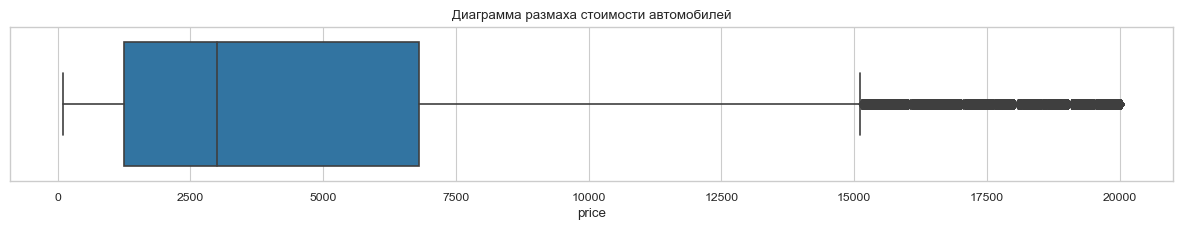

In [93]:
plt.figure(figsize=(15, 2))

sns.boxplot(x=data['price'])
plt.title("Диаграмма размаха стоимости автомобилей")

plt.show()

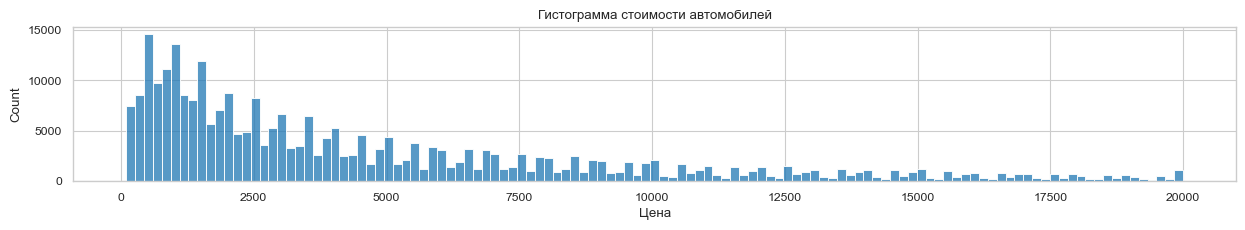

In [94]:
plt.figure(figsize=(15, 2))

sns.histplot(x=data['price'])

plt.title("Гистограмма стоимости автомобилей")
plt.xlabel("Цена")
plt.show()

Распределение нормальное и скошенное, с длинным хвостом, идущим в увеличение стоимости. Медиана и среднее сильно отличаются, 2950 и 4633 евро соответственно. Наблюдения с ценой выше 15000 показываются, как выбросы - посмотрим, сколько их.

In [95]:
data.query("price > 15000")

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,brand_model
13,17999,suv,2011,manual,190,navara,70000,gasoline,nissan,no,nissan _ navara
30,18000,sedan,2007,auto,218,3er,20000,petrol,bmw,no,bmw _ 3er
155,19750,convertible,2006,manual,305,mustang,50000,petrol,ford,no,ford _ mustang
162,16449,wagon,2015,auto,110,fabia,10000,petrol,skoda,no,skoda _ fabia
184,18400,wagon,2011,auto,313,5er,150000,gasoline,bmw,no,bmw _ 5er
...,...,...,...,...,...,...,...,...,...,...,...
296285,15190,bus,2011,manual,140,touran,80000,petrol,volkswagen,no,volkswagen _ touran
296359,16500,suv,2013,manual,116,i_reihe,30000,gasoline,hyundai,no,hyundai _ i_reihe
296364,16500,coupe,1973,manual,200,other,150000,petrol,bmw,yes,bmw _ other
296380,16999,wagon,2008,auto,269,a6,150000,gasoline,audi,no,audi _ a6


Этих наблюдений примерно 5%. Скорее всего, такая высокая цена связана с некоторыми элитными моделями автомобилей. Удалим эти наблюдения, так как это уникальные случаи для общего тренда.

In [96]:
price_anomaly_ind_2 = data.query("price > 15000").index

In [97]:
data.drop(price_anomaly_ind_2, inplace=True)

<h4>Столбец `registration_year`</h4>

In [98]:
data['registration_year'].sort_values().unique()

array([1000, 1001, 1234, 1300, 1400, 1500, 1600, 1602, 1800, 1910, 1923,
       1928, 1929, 1930, 1931, 1932, 1934, 1935, 1936, 1937, 1938, 1941,
       1942, 1943, 1945, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956,
       1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016], dtype=int64)

Настораживают авто с годом регистрации ранее 1923. Рассмотрим их:

In [99]:
data[data['registration_year'] < 1923]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,brand_model
14,450,small,1910,manual,0,ka,5000,petrol,ford,not specified,ford _ ka
9192,1250,wagon,1910,manual,0,other,5000,petrol,audi,not specified,audi _ other
14520,190,wagon,1000,manual,0,mondeo,5000,petrol,ford,not specified,ford _ mondeo
16461,7999,sedan,1500,manual,224,impreza,5000,petrol,subaru,not specified,subaru _ impreza
21393,3900,wagon,1910,manual,90,passat,150000,petrol,volkswagen,not specified,volkswagen _ passat
32210,200,other,1910,manual,0,caddy,150000,gasoline,volkswagen,not specified,volkswagen _ caddy
43751,600,small,1910,manual,0,agila,5000,petrol,opel,yes,opel _ agila
47832,330,small,1000,manual,0,polo,5000,petrol,volkswagen,not specified,volkswagen _ polo
50183,950,sedan,1400,manual,1400,golf,125000,petrol,volkswagen,not specified,volkswagen _ golf
55982,3400,small,1910,manual,90,beetle,90000,petrol,volkswagen,no,volkswagen _ beetle


Скорее всего, эти аномалии появились из-за технической ошибки. Их совсем немного, поэтому просто уберем данные аномалии:

In [100]:
reg_year_anomaly_ind = data.query("registration_year < 1923").index

In [101]:
data.drop(reg_year_anomaly_ind, inplace=True)

Посмотрим на статистики снова:

In [102]:
data['registration_year'].describe()

count    274198.000000
mean       2002.419959
std           6.455847
min        1923.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: registration_year, dtype: float64

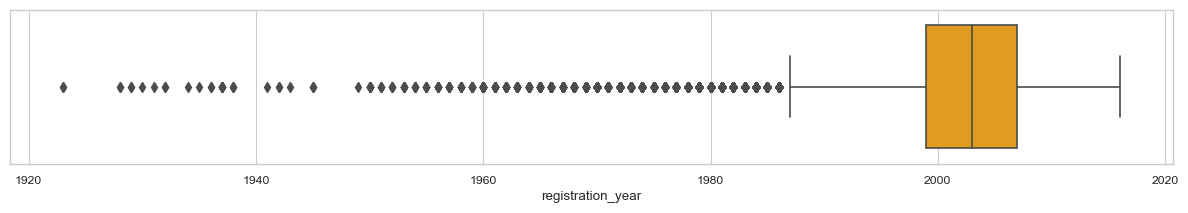

In [103]:
plt.figure(figsize=(15, 2))

sns.boxplot(x=data['registration_year'], color='orange')

plt.show()

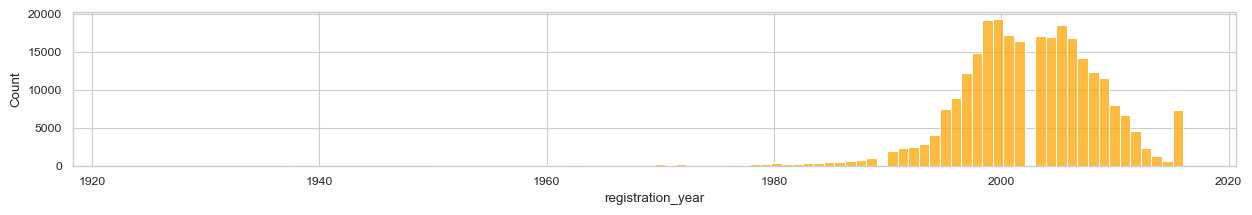

In [104]:
plt.figure(figsize=(15, 2))

sns.histplot(x=data['registration_year'], color='orange', bins=100)

plt.show()

Видим, что распределение нормальное (возможно бимодальное) с длинным хвостом влево. Посмотрим, сколько машин с годом регистрации старше 1980 года:

In [105]:
data.query("registration_year < 1980")

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,brand_model
326,10000,bus,1976,manual,0,transporter,5000,petrol,volkswagen,not specified,volkswagen _ transporter
484,4900,convertible,1973,manual,44,kaefer,90000,petrol,volkswagen,no,volkswagen _ kaefer
570,12000,sedan,1969,manual,140,s_klasse,80000,petrol,mercedes_benz,no,mercedes_benz _ s_klasse
889,2900,sedan,1971,auto,90,other,90000,petrol,opel,no,opel _ other
925,6500,other,1973,manual,54,other,50000,petrol,volkswagen,no,volkswagen _ other
...,...,...,...,...,...,...,...,...,...,...,...
295764,6000,sedan,1937,manual,38,other,5000,petrol,mercedes_benz,not specified,mercedes_benz _ other
296067,11500,suv,1976,manual,100,other,150000,petrol,jeep,not specified,jeep _ other
296069,800,sedan,1970,manual,0,other,150000,petrol,trabant,not specified,trabant _ other
296161,10500,convertible,1968,manual,54,other,20000,gasoline,renault,no,renault _ other


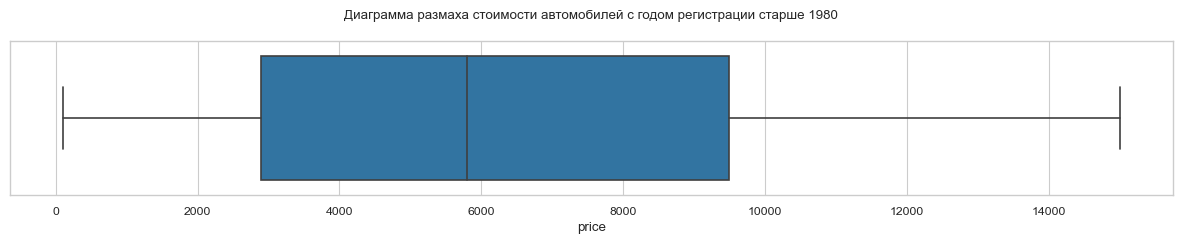

In [106]:
plt.figure(figsize=(15, 2))

sns.boxplot(x=data.query("registration_year < 1980")['price'])
plt.title("Диаграмма размаха стоимости автомобилей с годом регистрации старше 1980\n")
plt.show()

In [107]:
data.query("registration_year < 1980")['price'].describe()

count     1974.000000
mean      6304.889564
std       4107.204424
min        100.000000
25%       2892.250000
50%       5800.000000
75%       9486.750000
max      15000.000000
Name: price, dtype: float64

Итак, автомобилей с годом регистрации старше 1980 года достаточно мало - чуть более 2 тысяч из датасета размером в 300 тысяч - менее 1%. Часть этих авто имеет довольно высокую стоимость (их медианная цена также выше медианной по всему датасету) - скорее всего, это раритетные автомобили. Полагаю, что эти аномалии необходимо удалить, так как это уникальные случаи, идущие в разрез с обычным трендом стоимости - чем новее машина, тем она дороже.

In [108]:
reg_year_anomaly_ind_2 = data.query("registration_year < 1980").index

In [109]:
data.drop(reg_year_anomaly_ind_2, inplace=True)

Посмотрим, как изменилась диаграмма размаха по годам регистрации:

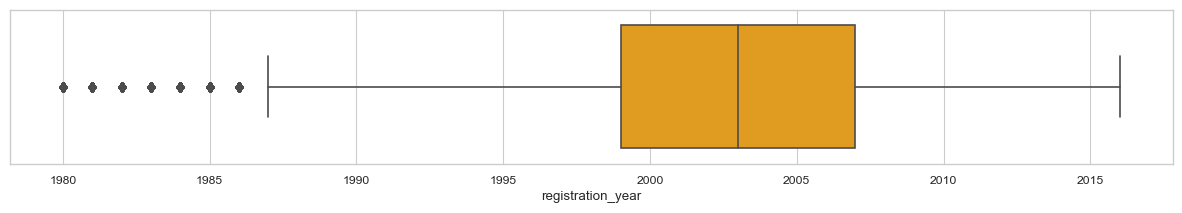

In [110]:
plt.figure(figsize=(15, 2))

sns.boxplot(x=data['registration_year'], color='orange')

plt.show()

Выбросов стало меньше, годы выглядят реалистично.

<h4>Столбец `power`</h4>

In [111]:
data['power'].describe()

count    272224.000000
mean        110.261671
std         186.407514
min           0.000000
25%          72.000000
50%         105.000000
75%         140.000000
max       20000.000000
Name: power, dtype: float64

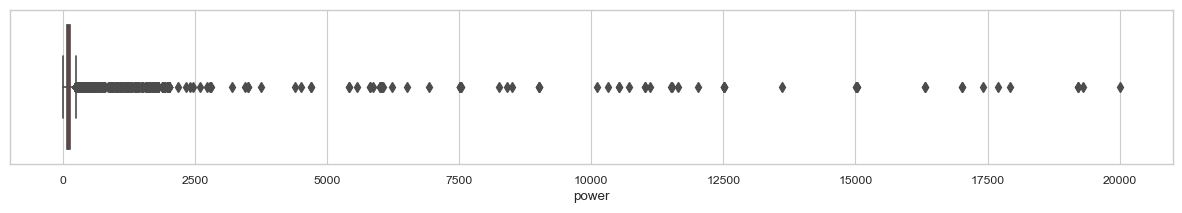

In [112]:
plt.figure(figsize=(15, 2))

sns.boxplot(x=data['power'], color='red')

plt.show()

Что-то явно не так с мощностью - на диаграмме размаха видны одни выбросы. Самый мощный автомобиль в мире имеет мощность чуть более 2000 л.с. Посмотрим на наблюдения с большей мощностью. Также мощность 0 л.с. настораживает.

In [113]:
data[data['power'] > 2000]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,brand_model
6929,1499,small,1999,manual,7515,lupo,150000,petrol,volkswagen,not specified,volkswagen _ lupo
17227,9750,wagon,2005,auto,2729,5er,150000,gasoline,bmw,no,bmw _ 5er
22729,10900,bus,2009,manual,10520,caddy,150000,gasoline,volkswagen,no,volkswagen _ caddy
30417,3740,small,2006,manual,6920,aygo,90000,petrol,toyota,no,toyota _ aygo
39849,2500,convertible,1998,manual,7512,golf,150000,petrol,volkswagen,not specified,volkswagen _ golf
...,...,...,...,...,...,...,...,...,...,...,...
286207,1899,other,2006,manual,7518,berlingo,125000,petrol,citroen,yes,citroen _ berlingo
290377,1300,sedan,2000,manual,12512,carisma,150000,petrol,mitsubishi,not specified,mitsubishi _ carisma
291560,850,sedan,1993,auto,9012,golf,150000,petrol,volkswagen,not specified,volkswagen _ golf
291644,3000,coupe,2007,manual,2007,corsa,150000,gasoline,opel,yes,opel _ corsa


Всего 86 аномалий, удалим их.

In [114]:
power_anomaly = data[data['power'] > 2000].index

In [115]:
data.drop(power_anomaly, inplace=True)

Посмотрим диаграмму размаха после удаления:

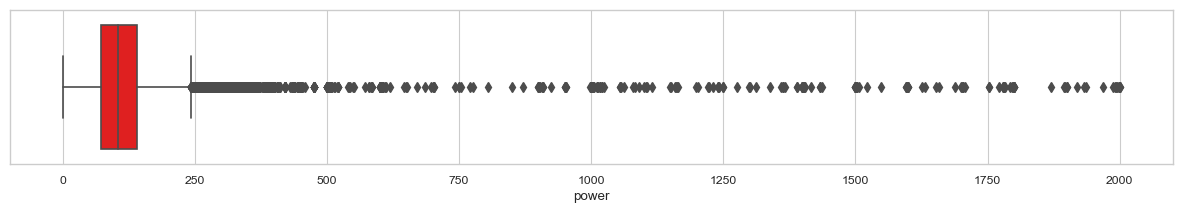

In [116]:
plt.figure(figsize=(15, 2))

sns.boxplot(x=data['power'], color='red')

plt.show()

Изучим авто с мощностью более 1000 л.с.:

In [117]:
data[data['power'] > 1000]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,brand_model
1647,3200,small,2004,manual,1398,corolla,5000,petrol,toyota,no,toyota _ corolla
4824,500,wagon,1999,manual,1001,astra,150000,petrol,opel,not specified,opel _ astra
8725,2599,bus,2016,manual,1779,zafira,150000,petrol,opel,no,opel _ zafira
8910,550,wagon,2003,manual,1753,focus,150000,gasoline,ford,yes,ford _ focus
17883,3390,sedan,2009,manual,1240,micra,60000,petrol,nissan,no,nissan _ micra
...,...,...,...,...,...,...,...,...,...,...,...
290661,450,sedan,1996,auto,1004,vectra,80000,petrol,opel,yes,opel _ vectra
291449,355,sedan,1998,manual,1799,vectra,150000,petrol,opel,not specified,opel _ vectra
292139,7500,sedan,2011,manual,1548,scenic,90000,petrol,renault,not specified,renault _ scenic
292204,250,small,1999,manual,1241,ypsilon,150000,petrol,lancia,yes,lancia _ ypsilon


Скорее всего, в этих мощностях ошибки. Удалим аномалии:

In [118]:
power_anomaly_2 = data[data['power'] > 1000].index

In [119]:
data.drop(power_anomaly_2, inplace=True)

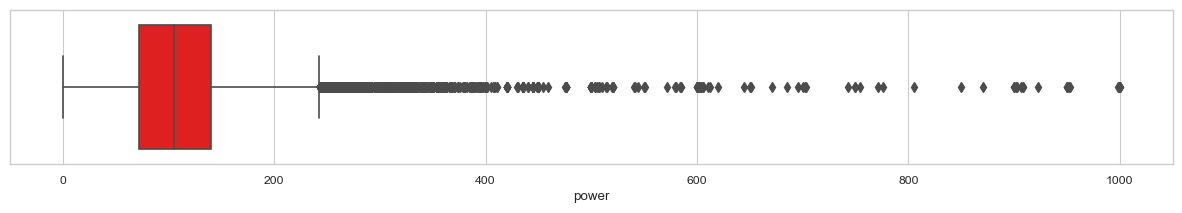

In [120]:
plt.figure(figsize=(15, 2))

sns.boxplot(x=data['power'], color='red')

plt.show()

Посмотрим на авто мощностью более 400 л.с.:

In [121]:
data[data['power'] > 400]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,brand_model
3688,3100,sedan,2005,manual,953,colt,150000,gasoline,mitsubishi,no,mitsubishi _ colt
4241,13900,sedan,2006,auto,476,e_klasse,150000,petrol,mercedes_benz,no,mercedes_benz _ e_klasse
4815,10999,wagon,2006,auto,435,other,150000,petrol,audi,yes,audi _ other
5704,599,small,2002,manual,603,matiz,5000,petrol,chevrolet,yes,chevrolet _ matiz
5884,3000,small,2009,manual,771,punto,125000,petrol,fiat,not specified,fiat _ punto
...,...,...,...,...,...,...,...,...,...,...,...
289098,1200,suv,2003,auto,450,cayenne,90000,petrol,porsche,yes,porsche _ cayenne
290997,8100,sedan,2001,auto,420,a8,150000,petrol,audi,no,audi _ a8
291602,14000,sedan,2003,auto,476,e_klasse,20000,petrol,mercedes_benz,no,mercedes_benz _ e_klasse
294409,10500,sedan,2003,auto,445,7er,150000,petrol,bmw,no,bmw _ 7er


Здесь в перемешку супер быстрый porsche действительно с мощностью 450 и обычный citroen, у которого мощность должна быть не 650, а 65 л.с.

Попробуем отфильтровать ошибки с помощью высокой цены:

In [122]:
data.query("price < 5000 & power >= 400")

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,brand_model
3688,3100,sedan,2005,manual,953,colt,150000,gasoline,mitsubishi,no,mitsubishi _ colt
5704,599,small,2002,manual,603,matiz,5000,petrol,chevrolet,yes,chevrolet _ matiz
5884,3000,small,2009,manual,771,punto,125000,petrol,fiat,not specified,fiat _ punto
6006,600,small,1996,manual,603,corsa,150000,petrol,opel,yes,opel _ corsa
7283,500,small,2002,manual,620,ypsilon,150000,petrol,lancia,not specified,lancia _ ypsilon
...,...,...,...,...,...,...,...,...,...,...,...
269351,3000,wagon,2000,auto,400,e_klasse,150000,lpg,mercedes_benz,not specified,mercedes_benz _ e_klasse
272162,399,coupe,2015,auto,430,911,5000,petrol,porsche,not specified,porsche _ 911
278309,4600,small,2008,manual,601,polo,80000,petrol,volkswagen,no,volkswagen _ polo
289098,1200,suv,2003,auto,450,cayenne,90000,petrol,porsche,yes,porsche _ cayenne


Все равно попадаются машины с неправильно указанной мощностью. Поэтому принимаем решение удалить авто мощностью более 400 л.с.

In [123]:
power_anomaly_3 = data.query("power >= 400").index

In [124]:
data.drop(power_anomaly_3, inplace=True)

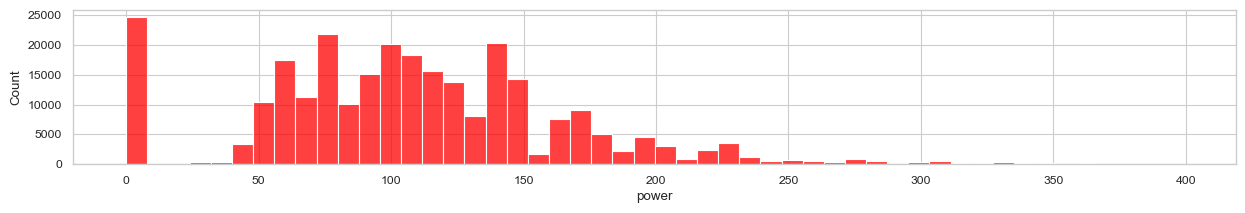

In [125]:
plt.figure(figsize=(15, 2))

sns.histplot(x=data['power'], color='red', bins=50)

plt.show()

На гистограмме видно, что правый хвост стал короче. Видим достаточно большой выброс около нуля, изучим его:

In [126]:
data.query("power <= 30").groupby('power').agg('count')

,price,vehicle_type,registration_year,gearbox,model,kilometer,fuel_type,brand,repaired,brand_model
power,,,,,,,,,,
0,24645,24645,24645,24645,24645,24645,24645,24645,24645,24645
1,13,13,13,13,13,13,13,13,13,13
2,4,4,4,4,4,4,4,4,4,4
3,1,1,1,1,1,1,1,1,1,1
4,5,5,5,5,5,5,5,5,5,5
5,13,13,13,13,13,13,13,13,13,13
6,4,4,4,4,4,4,4,4,4,4
7,3,3,3,3,3,3,3,3,3,3
8,4,4,4,4,4,4,4,4,4,4


In [127]:
data.query("power == 26")

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,brand_model
5141,650,sedan,1985,manual,26,601,30000,petrol,trabant,yes,trabant _ 601
5228,10000,sedan,1980,manual,26,601,40000,petrol,trabant,no,trabant _ 601
10422,5900,sedan,1989,manual,26,601,20000,petrol,trabant,no,trabant _ 601
16167,450,sedan,1988,manual,26,601,100000,petrol,trabant,not specified,trabant _ 601
16870,560,sedan,1988,manual,26,601,5000,petrol,trabant,not specified,trabant _ 601
...,...,...,...,...,...,...,...,...,...,...,...
285838,699,sedan,1990,manual,26,601,50000,petrol,trabant,not specified,trabant _ 601
289656,2500,wagon,1987,manual,26,601,5000,petrol,trabant,no,trabant _ 601
290306,2300,wagon,1982,manual,26,601,70000,petrol,trabant,no,trabant _ 601
292017,3500,sedan,1984,manual,26,601,70000,petrol,trabant,not specified,trabant _ 601


In [128]:
data.query("power == 5")

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,brand_model
30456,4999,small,2012,auto,5,other,5000,electric,renault,no,renault _ other
30799,655,other,1995,manual,5,other,70000,gasoline,seat,not specified,seat _ other
53036,999,convertible,1995,manual,5,punto,125000,petrol,fiat,no,fiat _ punto
69460,999,small,2000,manual,5,twingo,150000,petrol,renault,not specified,renault _ twingo
103793,6500,bus,2006,manual,5,5_reihe,150000,petrol,mazda,no,mazda _ 5_reihe
117642,1790,sedan,2002,manual,5,corsa,150000,petrol,opel,no,opel _ corsa
121166,360,small,1999,manual,5,twingo,150000,petrol,renault,not specified,renault _ twingo
128467,650,bus,1998,manual,5,kangoo,150000,petrol,renault,no,renault _ kangoo
135132,500,small,2016,manual,5,lupo,150000,petrol,volkswagen,no,volkswagen _ lupo
156411,700,small,2001,manual,5,polo,150000,petrol,volkswagen,no,volkswagen _ polo


In [129]:
data.query("power == 10")

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,brand_model
25827,700,sedan,2016,manual,10,vectra,150000,petrol,opel,not specified,opel _ vectra
49349,2671,wagon,2005,manual,10,touran,150000,gasoline,volkswagen,no,volkswagen _ touran
87168,200,small,2016,manual,10,corsa,150000,petrol,opel,no,opel _ corsa
136928,1199,sedan,2016,manual,10,golf,150000,petrol,volkswagen,no,volkswagen _ golf
211039,10200,bus,2010,manual,10,roomster,80000,petrol,skoda,not specified,skoda _ roomster
243022,350,small,1995,manual,10,corsa,150000,petrol,opel,no,opel _ corsa
248382,1490,sedan,2000,manual,10,astra,150000,petrol,opel,no,opel _ astra


In [130]:
data.query("power == 8")

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,brand_model
38455,4200,other,2012,auto,8,other,40000,electric,renault,no,renault _ other
64029,8000,small,2004,manual,8,viano,150000,gasoline,mercedes_benz,not specified,mercedes_benz _ viano
121037,1350,wagon,1999,manual,8,astra,150000,gasoline,opel,no,opel _ astra
282223,9299,wagon,2011,manual,8,golf,125000,gasoline,volkswagen,no,volkswagen _ golf


Получается, что есть модели с мощностью меньшей 30, также есть ошибочно указанные мощности. Автомобилей с мощностью равной 0 в датасете много, более 25 тысяч.

В данном случае заполним мощности меньшие 30 модой по модели и бренду.

In [131]:
for x in data[data['power'] < 30]['brand_model'].unique():
    data.loc[(data['power'] < 30) & (data['brand_model'] == x), 'power'] = \
    data.loc[(data['brand_model'] == x) & (data['power'] != 0), 'power'].mode()[0]

In [132]:
data[data['power'] < 30]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,brand_model
5141,650,sedan,1985,manual,26,601,30000,petrol,trabant,yes,trabant _ 601
5228,10000,sedan,1980,manual,26,601,40000,petrol,trabant,no,trabant _ 601
10422,5900,sedan,1989,manual,26,601,20000,petrol,trabant,no,trabant _ 601
16167,450,sedan,1988,manual,26,601,100000,petrol,trabant,not specified,trabant _ 601
16364,200,sedan,1990,manual,26,601,5000,petrol,trabant,not specified,trabant _ 601
...,...,...,...,...,...,...,...,...,...,...,...
291781,980,sedan,1983,manual,26,601,60000,petrol,trabant,not specified,trabant _ 601
292017,3500,sedan,1984,manual,26,601,70000,petrol,trabant,not specified,trabant _ 601
292254,1000,sedan,1989,manual,26,601,80000,petrol,trabant,not specified,trabant _ 601
295382,10000,other,1988,manual,26,601,5000,petrol,trabant,not specified,trabant _ 601


In [133]:
data[data['power'] < 30]['brand_model'].unique()

array(['trabant _ 601'], dtype=object)

Теперь только одна модель с мощностью меньше 30 - трабант 601, у которого действительно мощность равна 26 л.с.

![](https://wroom.ru/i/cars2/trabant_601_1_2.jpg)

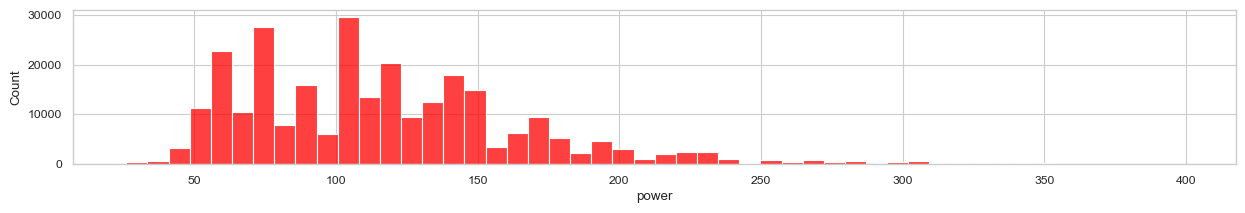

In [134]:
plt.figure(figsize=(15, 2))

sns.histplot(x=data['power'], color='red', bins=50)

plt.show()

Отлично, теперь аномально низких мощностей не наблюдается. Распределение нормальное, скошенное.

<h4>Столбец `kilometer`</h4>

In [135]:
data['kilometer'].describe()

count    271779.000000
mean     130477.759503
std       35185.385023
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

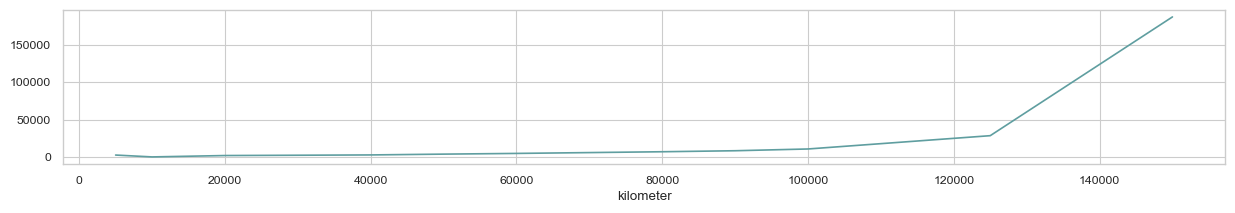

In [136]:
plt.figure(figsize=(15, 2))

data.groupby('kilometer')['kilometer'].agg('count').plot(kind='line', color='cadetblue')

plt.show()

Скорее всего, чаще продают автомобили с достаточно большим пробегом - этим обуславливается увеличение количества наблюдений после 100000 км.

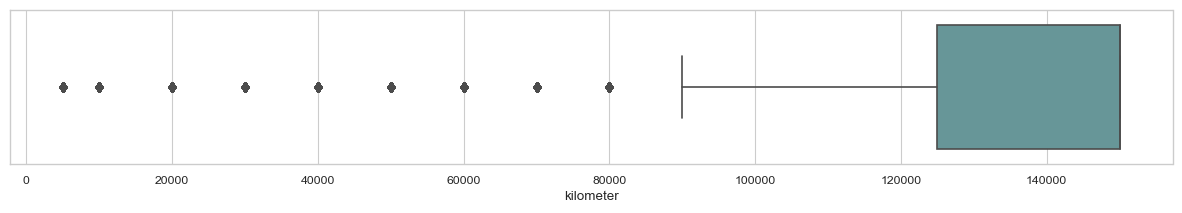

In [137]:
plt.figure(figsize=(15, 2))

sns.boxplot(x=data['kilometer'], color='cadetblue')

plt.show()

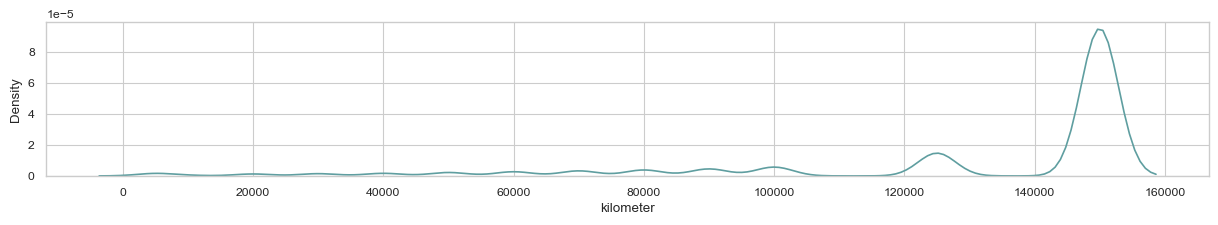

In [138]:
plt.figure(figsize=(15, 2))

sns.kdeplot(x=data['kilometer'], color='cadetblue')

plt.show()

Интересен пик на значении в 150000 км. Рассмотрим подробнее:

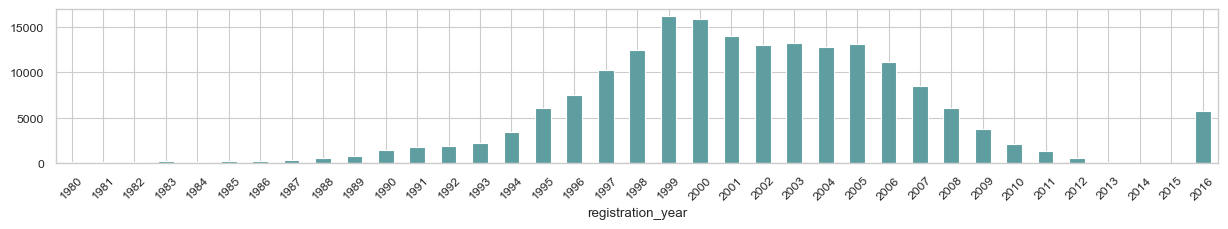

In [139]:
plt.figure(figsize=(15,2))

data[data['kilometer'] == 150000].groupby('registration_year')['registration_year']\
                                 .agg('count')\
                                 .plot(kind='bar', color='cadetblue')
plt.xticks(rotation=45)
plt.show()

Годы регистрации распределены нормально, имеется один пик у 2016 года, но, возможно, что это просто интенсивно использовавшиеся автомобили.

Оставим пробег в 150000 км. так, как есть - возможно, машины часто продают именно с таким пробегом.

Посмотрим на маленький пробег:

In [140]:
data[data['kilometer'] <= 80000]['kilometer'].sort_values().unique()

array([ 5000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000],
      dtype=int64)

In [141]:
data[data['kilometer'] <= 80000]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,brand_model
7,14500,bus,2014,manual,125,c_max,30000,petrol,ford,not specified,ford _ c_max
24,6900,sedan,2008,manual,99,civic,60000,petrol,honda,no,honda _ civic
25,1990,bus,1981,manual,50,transporter,5000,petrol,volkswagen,no,volkswagen _ transporter
33,1600,other,1991,manual,75,kadett,70000,petrol,opel,not specified,opel _ kadett
41,3900,small,2008,auto,61,fortwo,80000,petrol,smart,not specified,smart _ fortwo
...,...,...,...,...,...,...,...,...,...,...,...
296342,15000,sedan,2011,manual,125,a3,60000,petrol,audi,yes,audi _ a3
296344,15000,sedan,2013,auto,115,focus,60000,gasoline,ford,no,ford _ focus
296377,5990,bus,1984,auto,94,other,70000,petrol,chevrolet,not specified,chevrolet _ other
296384,6750,wagon,2009,manual,126,ceed,70000,petrol,kia,no,kia _ ceed


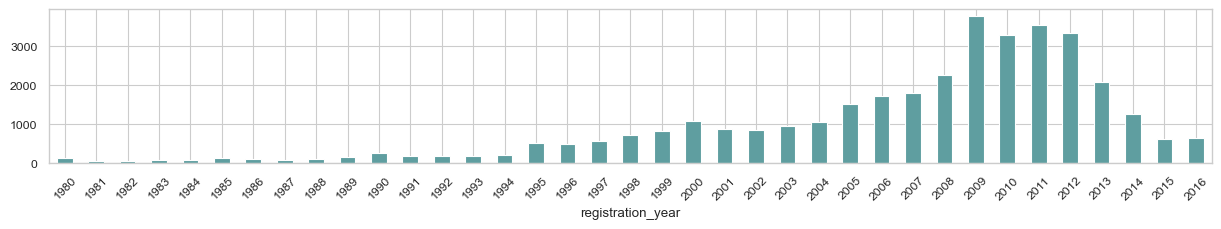

In [142]:
plt.figure(figsize=(15,2))
data[data['kilometer'] <= 80000].groupby('registration_year')['registration_year']\
                                .agg('count')\
                                .plot(kind='bar', color='cadetblue')
plt.xticks(rotation=45)
plt.show()

Годы регистрации выглядят нормально, большая часть наблюдений небольшого пробега у поздних годов, что логично.

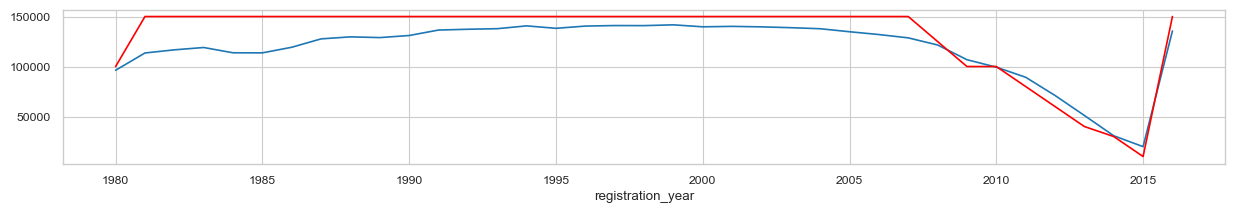

In [143]:
plt.figure(figsize=(15, 2))

data.groupby(['registration_year'])['kilometer'].agg('mean').plot(kind='line')
data.groupby(['registration_year'])['kilometer'].agg('median').plot(kind='line', color='red')

plt.show()

In [144]:
data[data['registration_year'] == 2015].groupby('kilometer').agg('count')

,price,vehicle_type,registration_year,gearbox,power,model,fuel_type,brand,repaired,brand_model
kilometer,,,,,,,,,,
5000,174,174,174,174,174,174,174,174,174,174
10000,173,173,173,173,173,173,173,173,173,173
20000,183,183,183,183,183,183,183,183,183,183
30000,52,52,52,52,52,52,52,52,52,52
40000,12,12,12,12,12,12,12,12,12,12
50000,12,12,12,12,12,12,12,12,12,12
60000,1,1,1,1,1,1,1,1,1,1
70000,1,1,1,1,1,1,1,1,1,1
80000,2,2,2,2,2,2,2,2,2,2


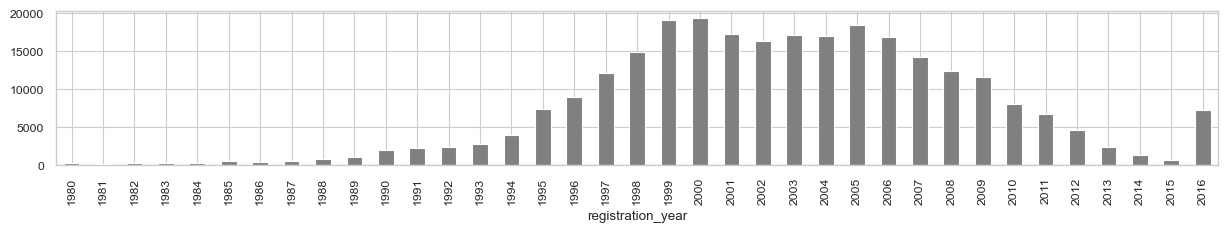

In [145]:
plt.figure(figsize=(15, 2))

data.groupby(['registration_year'])['registration_year'].agg('count').plot(kind='bar', color='grey')

plt.show()

У 2015 года регистрации мало наблюдений, по сравнению с остальными. Также в 2015 преобладает меньший пробег, чем в остальных годах. 

Распределения выглядят нормальными, причину выбросов и провалов на графиках выяснили. Оставим пробег, как есть, так как аномалии объясняются обычными тенденциями.

<h4>Исследование корреляции признаков</h4>

In [146]:
data.drop(columns='price').corr()

,registration_year,power,kilometer
registration_year,1.000000,0.086497,-0.295396
power,0.086497,1.000000,0.151127
kilometer,-0.295396,0.151127,1.000000


Как видим, по шкале Чеддока сила связи между независимыми признаками "слабая" (0.1 - 0.3). Значит, явления мультиколлинеарности признаков не должно быть.

<h3>Итог предобработки данных</h3>

In [147]:
round(100 - data.shape[0] / DF_LEN * 100)

23

In [148]:
data.shape[0]

271779

Итак, в процессе чистки и предобработки данных были удалены 23% наблюдений от исходного датасета. Мы столкнулись с противоречащими друг другу признаками, пропущенными значениями, аномальными значениями. Где возможно, пропущенные признаки были восстановлены, аномалии исправлены. 

Полагаю, что количество оставшихся объектов - 271 тысяча - позволит обучить точную модель для предсказания рыночной стоимости автомобиля.

<h3>Разделение данных на выборки</h3>

Перед нами задача прогнозирования рыночной стоимости автомобиля - то есть, задача регрессии. В качестве моделей, которые мы будем обучать и тестировать, возьмем LightGBM - модель градиентного бустинга по заданию, модель CatBoost - градиентный бустинг от Яндекса и модель линейной регрессии из sklearn.

В датасете имеются количественные и категориальные признаки. Для моделей CatBoost и LightGBM не требуется внешнее кодирование категориальных признаков, но для линейной регрессии требуется, поэтому, сначала обучим и протестируем модели градиентного бустинга, а после линейную модель. Для всех моделей произведем масштабирование количественных признаков.

<h4>Отделение целевого признака</h4>

Сначала разобьем датасет на **features** и **target**, а также удалим столбец `brand_model`, который создали для заполнения пропущенных значений.

In [149]:
data.reset_index(drop=True, inplace=True)

In [150]:
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired,brand_model
0,480,sedan,1993,manual,75,golf,150000,petrol,volkswagen,not specified,volkswagen _ golf
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,not specified,jeep _ grand
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,volkswagen _ golf
3,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,skoda _ fabia
4,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes,bmw _ 3er


In [151]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271779 entries, 0 to 271778
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              271779 non-null  int64 
 1   vehicle_type       271779 non-null  object
 2   registration_year  271779 non-null  int64 
 3   gearbox            271779 non-null  object
 4   power              271779 non-null  int64 
 5   model              271779 non-null  object
 6   kilometer          271779 non-null  int64 
 7   fuel_type          271779 non-null  object
 8   brand              271779 non-null  object
 9   repaired           271779 non-null  object
 10  brand_model        271779 non-null  object
dtypes: int64(4), object(7)
memory usage: 22.8+ MB


In [152]:
data.drop(columns='brand_model', inplace=True)

In [153]:
features = data.drop('price', axis=1)

In [154]:
features.shape[0]

271779

In [155]:
target = data['price']

In [156]:
target.shape[0]

271779

<h4>Разбиение на обучающую и тестовую выборки</h4>

In [157]:
features_train, features_test, target_train, target_test = \
        train_test_split(features, target, test_size=0.25, random_state=RS)

In [158]:
features_train = features_train.copy()

In [159]:
features_test = features_test.copy()

In [160]:
features_train.shape[0]

203834

In [161]:
features_test.shape[0]

67945

In [162]:
target_train.shape[0]

203834

In [163]:
target_test.shape[0]

67945

<h4>Масштабирование признаков</h4>

Определим столбцы с количественными признаками, которые будем масштабировать:

- `registration_year`
- `power`
- `kilometer`

In [164]:
numeric = ['registration_year', 'power', 'kilometer']

In [165]:
scaler = StandardScaler()
features_train[numeric] = scaler.fit_transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [166]:
features_train.describe()

,registration_year,power,kilometer
count,2.038340e+05,2.038340e+05,2.038340e+05
mean,9.012836e-15,5.155630e-17,-6.504669e-17
std,1.000002e+00,1.000002e+00,1.000002e+00
min,-3.864960e+00,-1.827653e+00,-3.576829e+00
25%,-6.216275e-01,-8.319141e-01,-1.580636e-01
50%,6.117941e-02,-1.409930e-01,5.541793e-01
75%,7.439863e-01,5.499281e-01,5.541793e-01
max,2.280302e+00,5.752158e+00,5.541793e-01


In [167]:
features_test.describe()

,registration_year,power,kilometer
count,67945.000000,67945.000000,67945.000000
mean,0.004187,-0.011971,-0.008015
std,1.004149,0.999662,1.009628
min,-3.864960,-1.827653,-3.576829
25%,-0.621627,-0.831914,-0.158064
50%,0.061179,-0.181635,0.554179
75%,0.743986,0.509286,0.554179
max,2.280302,5.752158,0.554179


Видим, что все отмасштабировалось. Можем приступать к обучению моделей LightGBM и CatBoost, так как для них не требуется кодирование категориальных признаков. Линейную регрессию обучим после, закодируем признаки непосредственно перед ее обучением.

## Обучение моделей

Требуемая по заданию метрика качества модели - среднеквадратическое отклонение, RMSE. Напишем функцию для ее вычисления.

In [168]:
def rmse(target, predictions):
    rmse = ((target - predictions)**2).mean()**0.5
    return rmse

<h4>Модель LightGBM</h4>

Для того, чтобы модель работала, присвоим категориальным признакам тип `category` в pandas:

In [169]:
rmse_scorer = make_scorer(rmse)

In [170]:
cat_feature=['vehicle_type', 'gearbox', 'power', 'model', 'brand', 'fuel_type', 'repaired']

In [171]:
features_train[cat_feature] = features_train[cat_feature].astype('category')

In [172]:
features_test[cat_feature] = features_test[cat_feature].astype('category')

Обучим несколько моделей и определим лучшую с помощью GridSearchCV - изменять будем гиперпараметры `num_leaves` и `max_depth`:

In [173]:
lgb = ltb.LGBMRegressor(random_state=RS)

In [174]:
lgb_params = [{'max_depth':[3, 5, 6, 7, 9, 12, 15, 17, 25], 'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5]}]

In [175]:
best_lgb = GridSearchCV(lgb, lgb_params, cv=5, scoring=rmse_scorer)

In [176]:
best_lgb.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=1212),
             param_grid=[{'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
                          'max_depth': [3, 5, 6, 7, 9, 12, 15, 17, 25]}],
             scoring=make_scorer(rmse))

Посмотрим на лучший результат:

In [177]:
best_lgb.best_params_

{'learning_rate': 0.1, 'max_depth': 3}

In [178]:
best_lgb.best_score_

1492.8488460118153

Итак, лучший результат, а именно RMSE = 1493 показала модель LightGBM с параметрами `learning_rate=0.1`, `max_depth=3`. Посмотрим, сколько времени занимает обучение данной модели на тренировочной и предсказание на тренировочной выборке с помощью команды %%time, сохраним время с помощью библиотеки time.

In [179]:
%%time
start = time.time()
model_ltb = ltb.LGBMRegressor(num_leaves=2, max_depth=1, random_state = RS)
model_ltb.fit(features_train, target_train)
end = time.time()
time_fit_lgb = end-start
print("Затраченное время:", round(time_fit_lgb, 2), "сек")

Затраченное время: 0.45 сек
CPU times: total: 3.64 s
Wall time: 452 ms


In [180]:
%%time
start = time.time()
lgb_predictions = model_ltb.predict(features_train)
end = time.time()
time_predict_lgb = end-start
print("Затраченное время:", round(time_predict_lgb, 2), "сек")

Затраченное время: 0.15 сек
CPU times: total: 1.53 s
Wall time: 150 ms


<h4>Модель CatBoost</h4>

Для модели CatBoost переведем категориальные столбцы в тип string. В качестве функции потерь будем использовать среднеквадратическое отклонение, изменять будем гиперпараметры iterations - количество итераций, и глубину - depth.

In [181]:
features_train[cat_feature] = features_train[cat_feature].astype('str')
features_test[cat_feature] = features_test[cat_feature].astype('str')

In [182]:
cat = ctb.CatBoostRegressor(loss_function="RMSE", random_state = RS, cat_features=cat_feature, verbose=False)

In [183]:
cat_params = [{'depth':[3, 5, 6, 7, 9, 12, 16], 'iterations':list(range(50, 100, 10)), }]

In [184]:
best_cat = GridSearchCV(cat, cat_params, cv=5, scoring=rmse_scorer)

In [185]:
best_cat.fit(features_train, target_train)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001755F5E11C0>,
             param_grid=[{'depth': [3, 5, 6, 7, 9, 12, 16],
                          'iterations': [50, 60, 70, 80, 90]}],
             scoring=make_scorer(rmse))

Посмотрим на лучший результат и параметры:

In [186]:
best_cat.best_params_

{'depth': 3, 'iterations': 50}

In [187]:
best_cat.best_score_

1631.3173494573725

Лучший результат, RMSE=1631, показала модель с глубиной 3 и 50 итерациями. Измерим скорость обучения и предсказания данной модели.

In [188]:
%%time
start = time.time()
model = ctb.CatBoostRegressor(iterations=50, depth=1, random_state = RS)
model.fit(features_train, target_train, cat_features=cat_feature, verbose=50)
end = time.time()
time_fit_cat = end-start
print("Затраченное время:", round(time_fit_cat, 2), "сек")

Learning rate set to 0.5
0:	learn: 3134.4982544	total: 18.4ms	remaining: 903ms
49:	learn: 1904.8954521	total: 682ms	remaining: 0us
Затраченное время: 1.15 сек
CPU times: total: 6.52 s
Wall time: 1.15 s


In [189]:
%%time
start = time.time()
cat_predictions = model.predict(features_train)
end = time.time()
time_predict_cat = end-start
print("Затраченное время:", round(time_predict_cat, 2), "сек")

Затраченное время: 0.36 сек
CPU times: total: 359 ms
Wall time: 357 ms


<h4>Модель линейной регрессии</h4>

Для начала закодируем данные с помощью One Hot Encoding из sklearn:

In [190]:
encoder = OneHotEncoder(categories='auto', handle_unknown = 'ignore')

In [191]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203834 entries, 99756 to 205960
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   vehicle_type       203834 non-null  object 
 1   registration_year  203834 non-null  float64
 2   gearbox            203834 non-null  object 
 3   power              203834 non-null  object 
 4   model              203834 non-null  object 
 5   kilometer          203834 non-null  float64
 6   fuel_type          203834 non-null  object 
 7   brand              203834 non-null  object 
 8   repaired           203834 non-null  object 
dtypes: float64(2), object(7)
memory usage: 15.6+ MB


In [192]:
features_train[cat_feature] = features_train[cat_feature].astype('category')

In [193]:
features_train_ohe = pd.DataFrame(encoder.fit_transform(features_train).toarray())

In [194]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203834 entries, 99756 to 205960
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   vehicle_type       203834 non-null  category
 1   registration_year  203834 non-null  float64 
 2   gearbox            203834 non-null  category
 3   power              203834 non-null  category
 4   model              203834 non-null  category
 5   kilometer          203834 non-null  float64 
 6   fuel_type          203834 non-null  category
 7   brand              203834 non-null  category
 8   repaired           203834 non-null  category
dtypes: category(7), float64(2)
memory usage: 6.4 MB


In [195]:
features_test[cat_feature] = features_test[cat_feature].astype('category')

In [196]:
features_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67945 entries, 216351 to 234330
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   vehicle_type       67945 non-null  category
 1   registration_year  67945 non-null  float64 
 2   gearbox            67945 non-null  category
 3   power              67945 non-null  category
 4   model              67945 non-null  category
 5   kilometer          67945 non-null  float64 
 6   fuel_type          67945 non-null  category
 7   brand              67945 non-null  category
 8   repaired           67945 non-null  category
dtypes: category(7), float64(2)
memory usage: 2.2 MB


In [197]:
features_test_ohe = pd.DataFrame(encoder.transform(features_test).toarray())

In [198]:
features_train_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203834 entries, 0 to 203833
Columns: 695 entries, 0 to 694
dtypes: float64(695)
memory usage: 1.1 GB


In [199]:
features_train_ohe.head()

,0,1,2,3,4,5,6,7,8,9,...,685,686,687,688,689,690,691,692,693,694
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [200]:
model = LinearRegression()

In [201]:
%%time
start = time.time()
model.fit(features_train_ohe, target_train)
end = time.time()
time_fit_lr = end-start
print("Затраченное время:", round(time_fit_lr, 2), "сек")

Затраченное время: 10.32 сек
CPU times: total: 59.3 s
Wall time: 10.3 s


In [202]:
%%time
start = time.time()
lr_predictions = model.predict(features_train_ohe)
end = time.time()
time_predict_lr = end-start
print("Затраченное время:", round(time_predict_lr, 2), "сек")

Затраченное время: 0.27 сек
CPU times: total: 719 ms
Wall time: 273 ms


In [203]:
lr_RMSE = rmse(target_train, lr_predictions)

In [204]:
lr_RMSE

1631.7685761459898

Мы получили отличный результат по RMSE=1632, но довольно большое время обучения.

<h4>Модель случайного леса</h4>

Для модели случайного леса закодируем данные с помощью ordinal encoding - порядкового кодирования.

In [205]:
encoder = OrdinalEncoder(categories='auto', handle_unknown='ignore')

In [206]:
features_train_ordinal = pd.DataFrame(encoder.fit_transform(features_train))

In [207]:
features_train_ordinal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203834 entries, 0 to 203833
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       203834 non-null  float64
 1   1       203834 non-null  float64
 2   2       203834 non-null  float64
 3   3       203834 non-null  float64
 4   4       203834 non-null  float64
 5   5       203834 non-null  float64
 6   6       203834 non-null  float64
 7   7       203834 non-null  float64
 8   8       203834 non-null  float64
dtypes: float64(9)
memory usage: 14.0 MB


In [208]:
features_test_ordinal = pd.DataFrame(encoder.transform(features_test))

In [209]:
features_test_ordinal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67945 entries, 0 to 67944
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       67945 non-null  float64
 1   1       67945 non-null  float64
 2   2       67945 non-null  float64
 3   3       67945 non-null  float64
 4   4       67945 non-null  float64
 5   5       67945 non-null  float64
 6   6       67945 non-null  float64
 7   7       67945 non-null  float64
 8   8       67945 non-null  float64
dtypes: float64(9)
memory usage: 4.7 MB


In [210]:
rf = RandomForestRegressor(random_state = RS)

In [211]:
rf_params = [{'max_depth':list(range(1, 6)), 'n_estimators':list(range(10, 100, 10))}]

In [212]:
best_rf = GridSearchCV(rf, rf_params, cv=5, scoring=rmse_scorer)

In [213]:
best_rf.fit(features_train_ordinal, target_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1212),
             param_grid=[{'max_depth': [1, 2, 3, 4, 5],
                          'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80,
                                           90]}],
             scoring=make_scorer(rmse))

In [214]:
best_rf.best_params_

{'max_depth': 1, 'n_estimators': 10}

In [215]:
best_rf.best_score_

2933.862250565435

In [216]:
model = RandomForestRegressor(max_depth = 1, n_estimators = 10)

In [217]:
%%time
start = time.time()
model.fit(features_train_ordinal, target_train)
end = time.time()
time_fit_rf = end-start
print("Затраченное время:", round(time_fit_rf, 2), "сек")

Затраченное время: 0.43 сек
CPU times: total: 422 ms
Wall time: 431 ms


In [218]:
%%time
start = time.time()
rf_predictions = model.predict(features_train_ordinal)
end = time.time()
time_predict_rf = end-start
print("Затраченное время:", round(time_predict_rf, 2), "сек")

Затраченное время: 0.04 сек
CPU times: total: 46.9 ms
Wall time: 43.7 ms


Лучший результат случайного леса был достигнут моделью с максимальной глубиной решающего дерева равной 1 и 10 деревьями в ансамбле, RMSE=2934.

<h3>Проверка моделей на адекватность</h3>

<h4>Константная модель</h4>

В качестве константной модели выберем модель, предсказание которой будет являться средним значением целевого признака.

In [219]:
check_predictions = pd.Series(target_test.mean(), index=range(len(target_test)))

In [220]:
check_rmse = rmse(target_test, check_predictions)

In [221]:
check_rmse

3675.5084178812717

Все тестируемые нами модели показали результат лучший, чем константная модель.

## Анализ моделей

Итак, мы протестировали две модели градиентного бустинга, одну модель случайного леса и одну модель линейной регрессии. Построим датафрейм с временем обучения, предсказания и среднеквадратическим отклонением каждой модели.

In [222]:
l = [best_lgb.best_score_, time_fit_lgb, time_predict_lgb]
c = [best_cat.best_score_, time_fit_cat, time_predict_cat]
f = [best_rf.best_score_, time_fit_rf, time_predict_rf]
lr = [lr_RMSE, time_fit_lr, time_predict_lr]

In [223]:
result = (pd.DataFrame({'LightGBM':l, 'CatBoost':c, 'RandomForest':f, 'LinearRegression':lr},\
                       index=['RMSE', 'time_fit', 'time_predict'])).T

In [224]:
result

,RMSE,time_fit,time_predict
LightGBM,1492.848846,0.451856,0.149791
CatBoost,1631.317349,1.146752,0.356624
RandomForest,2933.862251,0.430530,0.043679
LinearRegression,1631.768576,10.316303,0.272799


In [225]:
result.sort_values(by='time_fit')

,RMSE,time_fit,time_predict
RandomForest,2933.862251,0.430530,0.043679
LightGBM,1492.848846,0.451856,0.149791
CatBoost,1631.317349,1.146752,0.356624
LinearRegression,1631.768576,10.316303,0.272799


In [226]:
result.sort_values(by='time_predict')

,RMSE,time_fit,time_predict
RandomForest,2933.862251,0.430530,0.043679
LightGBM,1492.848846,0.451856,0.149791
LinearRegression,1631.768576,10.316303,0.272799
CatBoost,1631.317349,1.146752,0.356624


In [227]:
result.sort_values(by='RMSE')

,RMSE,time_fit,time_predict
LightGBM,1492.848846,0.451856,0.149791
CatBoost,1631.317349,1.146752,0.356624
LinearRegression,1631.768576,10.316303,0.272799
RandomForest,2933.862251,0.430530,0.043679


Итак, по среднеквадратическому отклонению лучшей стала модель LightGBM.

По скорости обучения лидером стала тоже модель LightGBM.

Лидером по времени предсказания является модель случайного леса, но, учитывая ее низкое RMSE, рассматривать ее в качестве кандитата итоговой модели для мобильного приложения не стоит. На втором месте находится модель LightGBM.

Получается, что лучшая из всех моделей для конкретной задачи, исходя из требований заказчика, это модель LightGBM.

## Тестирование лучшей модели

Лучшие параметры для модели, которые удалось найти с помощью GridSearchCV на обучающей выборки это скорость обучения равная 0.1 и максимальная глубина деревьев равная трем. Обучим градиентный бустинг с данными параметрами на тренировочной выборке и сделаем предсказания по тестовой выборке для того, чтобы узнать финальное RMSE.

In [228]:
model_ltb = ltb.LGBMRegressor(random_state=RS, learning_rate = 0.1, max_depth = 3)

In [229]:
model_ltb.fit(features_train, target_train)

LGBMRegressor(max_depth=3, random_state=1212)

In [230]:
ltb_test_predictions = model_ltb.predict(features_test)

In [231]:
ltb_final_rmse = rmse(target_test, ltb_test_predictions)

In [232]:
ltb_final_rmse

1511.1579208600886

На тестовой выборке модель LightGBM показала значение среднеквадратического отклонения равное 1511. Это меньше допустимого значения равного 2500. По итогам исследования, это финальная модель для заказчика.

<h2>Вывод</h2>

Перед началом работы с моделями мы изучили данные, произвели их предобработку, убрали аномалии и пропущенные значения. После мы обучили несколько сложных (градиентный бустинг) и простых моделей (константная модель, линейная регрессия, случайный лес). В результате анализа моделей лучше всего проявила себя модель LightGBM. С ее помощью удалось достичь быстрых и точных предсказаний стоимости.